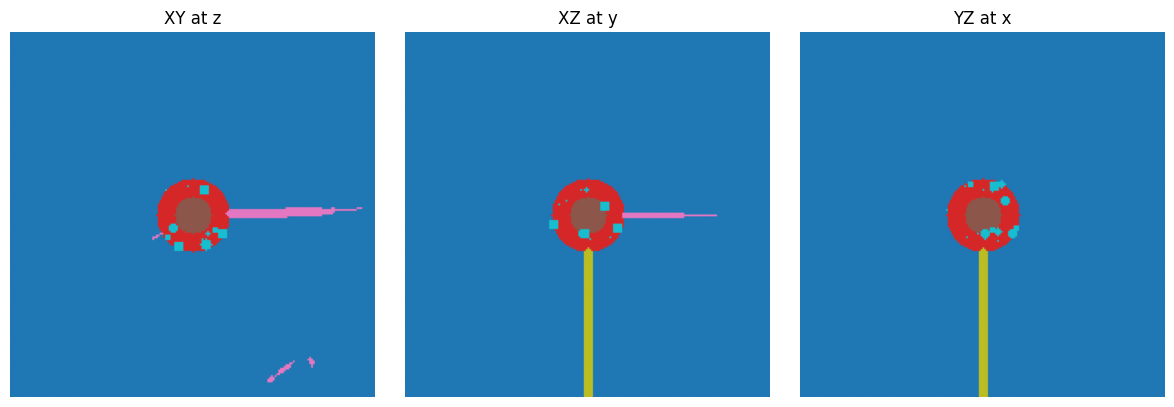

In [ ]:
import numpy as np

def generate_synthetic_neuron3d(
    shape=(200,200,200),
    soma_center=None,
    soma_radius=20,
    nucleus_ratio=0.5,
    num_mito=100,
    mito_radius_range=(1,3),
    num_dendrites=5,
    dend_depth=3,
    dend_length=50,
    dend_radius=2,
    axon_length=80,
    axon_radius=2
):
    """
    Returns a 3D label volume of a synthetic neuron:
      0: background
      2: soma
      3: nucleus
      4: dendrites
      5: axon
      6: mitochondria
    """
    # Label codes
    SOMA, NUC, DEND, AXON, MITO = 2,3,4,5,6

    nz, ny, nx = shape
    if soma_center is None:
        soma_center = np.array([nz//2, ny//2, nx//2], dtype=float)
    else:
        soma_center = np.array(soma_center, dtype=float)

    # grid coordinates
    zz, yy, xx = np.indices(shape)

    labels = np.zeros(shape, dtype=np.uint8)

    # 1) Soma: sphere of radius soma_radius
    dist2 = ((zz-soma_center[0])**2 +
             (yy-soma_center[1])**2 +
             (xx-soma_center[2])**2)
    mask_soma = dist2 <= soma_radius**2
    labels[mask_soma] = SOMA

    # 2) Nucleus: sphere of radius nucleus_ratio * soma_radius
    r_nuc = soma_radius * nucleus_ratio
    mask_nuc = dist2 <= r_nuc**2
    labels[mask_nuc] = NUC

    # 3) Mitochondria: random small spheres in soma shell
    rng = np.random.default_rng()
    for _ in range(num_mito):
        # sample a point in the shell
        while True:
            dz = rng.uniform(-soma_radius, soma_radius)
            dy = rng.uniform(-soma_radius, soma_radius)
            dx = rng.uniform(-soma_radius, soma_radius)
            if r_nuc**2 < dz*dz+dy*dy+dx*dx <= soma_radius**2:
                z0,y0,x0 = (soma_center + (dz,dy,dx)).astype(int)
                if 0<=z0<nz and 0<=y0<ny and 0<=x0<nx:
                    break
        r_m = rng.integers(mito_radius_range[0], mito_radius_range[1]+1)
        # carve mitochondrion
        m2 = ((zz-z0)**2 + (yy-y0)**2 + (xx-x0)**2) <= r_m**2
        labels[m2] = MITO

    # helper to carve a cylinder between p0→p1
    def carve_cylinder(p0, p1, radius, code):
        vec = p1 - p0
        length = np.linalg.norm(vec)
        if length<1: return
        steps = int(np.ceil(length*2))
        for t in np.linspace(0,1,steps):
            pos = p0 + vec*t
            zi, yi, xi = np.round(pos).astype(int)
            rz = int(radius)
            for dz in range(-rz,rz+1):
                for dy in range(-rz,rz+1):
                    for dx in range(-rz,rz+1):
                        if dz*dz+dy*dy+dx*dx <= radius*radius:
                            z_,y_,x_ = zi+dz, yi+dy, xi+dx
                            if (0<=z_<nz and 0<=y_<ny and 0<=x_<nx):
                                labels[z_,y_,x_] = code

    # recursive branching for dendrites/axon
    def branch(p0, direction, depth, max_depth, length, radius, code):
        if depth>max_depth: return
        dirn = direction/np.linalg.norm(direction)
        p1 = p0 + dirn*length
        carve_cylinder(p0, p1, radius, code)
        # generate two child branches
        for _ in range(2):
            # perturb direction
            d2 = dirn + 0.5*(rng.standard_normal(3))
            branch(p1, d2, depth+1, max_depth,
                   length*0.7, max(1,radius-1), code)

    # 4) Dendrites: radiate from soma surface in random directions
    for _ in range(num_dendrites):
        theta = 2*np.pi*rng.random()
        phi   = np.pi*(rng.random()-0.5)
        dir0  = np.array([
            np.cos(phi)*np.cos(theta),
            np.cos(phi)*np.sin(theta),
            np.sin(phi)
        ])
        # start at soma surface
        p0 = soma_center + dir0*soma_radius
        branch(p0, dir0, depth=0, max_depth=dend_depth,
               length=dend_length, radius=dend_radius,
               code=DEND)

    # 5) Axon: one long primary branch (no jitter at depth=0)
    axon_dir = np.array([1.0,0.0,0.0])  # e.g. +Z axis
    p0 = soma_center + axon_dir*soma_radius
    branch(p0, axon_dir, depth=0, max_depth=1,
           length=axon_length, radius=axon_radius,
           code=AXON)

    return labels


# Example usage:
if __name__=="__main__":
    vol = generate_synthetic_neuron3d()
    # e.g. visualize three orthogonal slices:
    import matplotlib.pyplot as plt
    cz, cy, cx = np.array(vol.shape)//2
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(vol[cz], cmap='tab10'); ax[0].set_title('XY at z')
    ax[1].imshow(vol[:,cy,:], cmap='tab10'); ax[1].set_title('XZ at y')
    ax[2].imshow(vol[:,:,cx], cmap='tab10'); ax[2].set_title('YZ at x')
    for a in ax: a.axis('off')
    plt.tight_layout(); plt.show()


In [ ]:
import k3d
import numpy as np
from k3d.colormaps import matplotlib_color_maps as cmaps

# 1) regenerate or pull in your volume
# from your_module import generate_synthetic_neuron3d
# vol = generate_synthetic_neuron3d(...)

# 2) transpose to X×Y×Z
vol_t = vol.transpose(2,1,0).astype(np.uint8)

# 3) pick a colormap that exists
#    e.g. 'tab20' for up to 20 distinct categories
colormap = cmaps['gray']

# 4) make the plot
plot = k3d.plot(grid_visible=False, background_color=0x000000)

vol_obj = k3d.volume(
    vol_t,
    color_map=colormap,
    color_range=[2, 6],     # only map labels 2–6
    alpha_coef=0.2,
    rendering_method='iso'   # try 'mip' or 'iso'
)
plot += vol_obj

# 5) display inline
plot.display()


AttributeError: module 'k3d.colormaps.matplotlib_color_maps' has no attribute 'GlasbeyCategory10'